# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.data.transform.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "model_energy":{
        "module_name": "kgcnn.literature.Schnet", 
        "class_name":"make_model", 
        "config":{
            "name": "Schnet",
            "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                       {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                       {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
            "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
            "make_distance": True, "expand_distance": True,
            "interaction_args": {"units": 128, "use_bias": True,
                                 "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
            "node_pooling_args": {"pooling_method": "sum"},
            "depth": 4,
            "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
            "verbose": 10,
            "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                         "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
            "output_embedding": "graph", "output_to_tensor": True,
            "use_output_mlp": True,
            "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                           "activation": ["kgcnn>shifted_softplus", "linear"]}}
    },
    "output_as_dict":True,
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model_config["model_energy"]["config"]["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 4s 27ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 10s - loss: 18.9855 - energy_loss: 0.2639 - force_loss: 0.9361 - 10s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 18.9360 - energy_loss: 0.2149 - force_loss: 0.9361 - 529ms/epoch - 66ms/step
Epoch 3/1500
8/8 - 1s - loss: 18.9204 - energy_loss: 0.2088 - force_loss: 0.9356 - 526ms/epoch - 66ms/step
Epoch 4/1500
8/8 - 1s - loss: 18.8879 - energy_loss: 0.2115 - force_loss: 0.9338 - 525ms/epoch - 66ms/step
Epoch 5/1500
8/8 - 1s - loss: 18.7421 - energy_loss: 0.2269 - force_loss: 0.9258 - 528ms/epoch - 66ms/step
Epoch 6/1500
8/8 - 1s - loss: 18.4477 - energy_loss: 0.3485 - force_loss: 0.9050 - 521ms/epoch - 65ms/step
Epoch 7/1500
8/8 - 1s - loss: 18.2400 - energy_loss: 0.7082 - force_loss: 0.8766 - 521ms/epoch - 65ms/step
Epoch 8/1500
8/8 - 1s - loss: 17.4148 - energy_loss: 0.5016 - force_loss: 0.8457 - 528ms/epoch - 66ms/step
Epoch 9/1500
8/8 - 1s - loss: 16.6695 - energy_loss: 0.8156 - force_loss: 0.7927 - 523ms/epoch - 65ms/step
Epoch 10/1500
8/8 - 1s - loss: 16.1980 - energy_loss:

Epoch 78/1500
8/8 - 1s - loss: 6.3916 - energy_loss: 0.8406 - force_loss: 0.2775 - 558ms/epoch - 70ms/step
Epoch 79/1500
8/8 - 1s - loss: 6.3917 - energy_loss: 0.8836 - force_loss: 0.2754 - 552ms/epoch - 69ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.3593 - energy_loss: 0.8830 - force_loss: 0.2738 - 549ms/epoch - 69ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.3015 - energy_loss: 0.8547 - force_loss: 0.2723 - 550ms/epoch - 69ms/step
Epoch 82/1500
8/8 - 1s - loss: 6.3299 - energy_loss: 0.8978 - force_loss: 0.2716 - 570ms/epoch - 71ms/step
Epoch 83/1500
8/8 - 1s - loss: 6.3444 - energy_loss: 0.8719 - force_loss: 0.2736 - 558ms/epoch - 70ms/step
Epoch 84/1500
8/8 - 1s - loss: 6.2206 - energy_loss: 0.8348 - force_loss: 0.2693 - 584ms/epoch - 73ms/step
Epoch 85/1500
8/8 - 1s - loss: 6.1736 - energy_loss: 0.8506 - force_loss: 0.2661 - 564ms/epoch - 70ms/step
Epoch 86/1500
8/8 - 1s - loss: 6.2194 - energy_loss: 0.9045 - force_loss: 0.2657 - 527ms/epoch - 66ms/step
Epoch 87/1500
8/8 - 1s - loss: 6.0940

8/8 - 1s - loss: 4.4628 - energy_loss: 0.6761 - force_loss: 0.1893 - 519ms/epoch - 65ms/step
Epoch 155/1500
8/8 - 1s - loss: 4.3543 - energy_loss: 0.6477 - force_loss: 0.1853 - 519ms/epoch - 65ms/step
Epoch 156/1500
8/8 - 1s - loss: 4.3279 - energy_loss: 0.6993 - force_loss: 0.1814 - 521ms/epoch - 65ms/step
Epoch 157/1500
8/8 - 1s - loss: 4.2507 - energy_loss: 0.6546 - force_loss: 0.1798 - 520ms/epoch - 65ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.2010 - energy_loss: 0.6542 - force_loss: 0.1773 - 520ms/epoch - 65ms/step
Epoch 159/1500
8/8 - 1s - loss: 4.2394 - energy_loss: 0.6710 - force_loss: 0.1784 - 524ms/epoch - 65ms/step
Epoch 160/1500
8/8 - 1s - loss: 4.1398 - energy_loss: 0.6617 - force_loss: 0.1739 - 533ms/epoch - 67ms/step
Epoch 161/1500
8/8 - 1s - loss: 4.1776 - energy_loss: 0.6633 - force_loss: 0.1757 - 584ms/epoch - 73ms/step
Epoch 162/1500
8/8 - 1s - loss: 4.3293 - energy_loss: 0.6225 - force_loss: 0.1853 - 559ms/epoch - 70ms/step
Epoch 163/1500
8/8 - 1s - loss: 4.5120 - en

Epoch 230/1500
8/8 - 1s - loss: 3.8935 - energy_loss: 0.8953 - force_loss: 0.1499 - 544ms/epoch - 68ms/step
Epoch 231/1500
8/8 - 1s - loss: 4.0727 - energy_loss: 0.8717 - force_loss: 0.1600 - 527ms/epoch - 66ms/step
Epoch 232/1500
8/8 - 1s - loss: 4.0873 - energy_loss: 0.6566 - force_loss: 0.1715 - 531ms/epoch - 66ms/step
Epoch 233/1500
8/8 - 1s - loss: 4.2606 - energy_loss: 0.6101 - force_loss: 0.1825 - 631ms/epoch - 79ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.8163 - energy_loss: 0.5421 - force_loss: 0.1637 - 542ms/epoch - 68ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.6768 - energy_loss: 0.5821 - force_loss: 0.1547 - 554ms/epoch - 69ms/step
Epoch 236/1500
8/8 - 1s - loss: 4.1428 - energy_loss: 1.0434 - force_loss: 0.1550 - 535ms/epoch - 67ms/step
Epoch 237/1500
8/8 - 1s - loss: 4.1626 - energy_loss: 0.9146 - force_loss: 0.1624 - 585ms/epoch - 73ms/step
Epoch 238/1500
8/8 - 1s - loss: 4.1190 - energy_loss: 0.9576 - force_loss: 0.1581 - 530ms/epoch - 66ms/step
Epoch 239/1500
8/8 - 1s - lo

Epoch 306/1500
8/8 - 1s - loss: 3.4714 - energy_loss: 0.6154 - force_loss: 0.1428 - 544ms/epoch - 68ms/step
Epoch 307/1500
8/8 - 1s - loss: 3.1766 - energy_loss: 0.4709 - force_loss: 0.1353 - 588ms/epoch - 73ms/step
Epoch 308/1500
8/8 - 1s - loss: 3.3820 - energy_loss: 0.5154 - force_loss: 0.1433 - 529ms/epoch - 66ms/step
Epoch 309/1500
8/8 - 1s - loss: 3.2937 - energy_loss: 0.5189 - force_loss: 0.1387 - 527ms/epoch - 66ms/step
Epoch 310/1500
8/8 - 1s - loss: 3.1643 - energy_loss: 0.4990 - force_loss: 0.1333 - 595ms/epoch - 74ms/step
Epoch 311/1500
8/8 - 1s - loss: 2.8280 - energy_loss: 0.2861 - force_loss: 0.1271 - 592ms/epoch - 74ms/step
Epoch 312/1500
8/8 - 1s - loss: 2.7583 - energy_loss: 0.2160 - force_loss: 0.1271 - 530ms/epoch - 66ms/step
Epoch 313/1500
8/8 - 1s - loss: 3.0043 - energy_loss: 0.4883 - force_loss: 0.1258 - 531ms/epoch - 66ms/step
Epoch 314/1500
8/8 - 1s - loss: 3.0031 - energy_loss: 0.5319 - force_loss: 0.1236 - 602ms/epoch - 75ms/step
Epoch 315/1500
8/8 - 1s - lo

Epoch 382/1500
8/8 - 1s - loss: 3.3465 - energy_loss: 0.8781 - force_loss: 0.1234 - 521ms/epoch - 65ms/step
Epoch 383/1500
8/8 - 1s - loss: 2.7519 - energy_loss: 0.2351 - force_loss: 0.1258 - 518ms/epoch - 65ms/step
Epoch 384/1500
8/8 - 1s - loss: 2.5531 - energy_loss: 0.2215 - force_loss: 0.1166 - 518ms/epoch - 65ms/step
Epoch 385/1500
8/8 - 1s - loss: 2.5179 - energy_loss: 0.1963 - force_loss: 0.1161 - 521ms/epoch - 65ms/step
Epoch 386/1500
8/8 - 1s - loss: 2.5689 - energy_loss: 0.2851 - force_loss: 0.1142 - 521ms/epoch - 65ms/step
Epoch 387/1500
8/8 - 1s - loss: 2.8183 - energy_loss: 0.4907 - force_loss: 0.1164 - 519ms/epoch - 65ms/step
Epoch 388/1500
8/8 - 1s - loss: 2.8113 - energy_loss: 0.4597 - force_loss: 0.1176 - 521ms/epoch - 65ms/step
Epoch 389/1500
8/8 - 1s - loss: 2.8169 - energy_loss: 0.4046 - force_loss: 0.1206 - 518ms/epoch - 65ms/step
Epoch 390/1500
8/8 - 1s - loss: 3.3840 - energy_loss: 0.4883 - force_loss: 0.1448 - 521ms/epoch - 65ms/step
Epoch 391/1500
8/8 - 1s - lo

Epoch 458/1500
8/8 - 1s - loss: 2.8148 - energy_loss: 0.4709 - force_loss: 0.1172 - 525ms/epoch - 66ms/step
Epoch 459/1500
8/8 - 1s - loss: 2.7499 - energy_loss: 0.4157 - force_loss: 0.1167 - 522ms/epoch - 65ms/step
Epoch 460/1500
8/8 - 1s - loss: 2.7532 - energy_loss: 0.3886 - force_loss: 0.1182 - 519ms/epoch - 65ms/step
Epoch 461/1500
8/8 - 1s - loss: 2.8223 - energy_loss: 0.4108 - force_loss: 0.1206 - 521ms/epoch - 65ms/step
Epoch 462/1500
8/8 - 1s - loss: 2.9854 - energy_loss: 0.4869 - force_loss: 0.1249 - 522ms/epoch - 65ms/step
Epoch 463/1500
8/8 - 1s - loss: 3.0494 - energy_loss: 0.4613 - force_loss: 0.1294 - 538ms/epoch - 67ms/step
Epoch 464/1500
8/8 - 1s - loss: 2.7519 - energy_loss: 0.4831 - force_loss: 0.1134 - 548ms/epoch - 68ms/step
Epoch 465/1500
8/8 - 1s - loss: 2.7201 - energy_loss: 0.4938 - force_loss: 0.1113 - 543ms/epoch - 68ms/step
Epoch 466/1500
8/8 - 1s - loss: 2.5127 - energy_loss: 0.3707 - force_loss: 0.1071 - 526ms/epoch - 66ms/step
Epoch 467/1500
8/8 - 1s - lo

Epoch 534/1500
8/8 - 1s - loss: 2.5318 - energy_loss: 0.5238 - force_loss: 0.1004 - 518ms/epoch - 65ms/step
Epoch 535/1500
8/8 - 1s - loss: 2.4597 - energy_loss: 0.4242 - force_loss: 0.1018 - 524ms/epoch - 66ms/step
Epoch 536/1500
8/8 - 1s - loss: 2.6880 - energy_loss: 0.3996 - force_loss: 0.1144 - 526ms/epoch - 66ms/step
Epoch 537/1500
8/8 - 1s - loss: 2.6562 - energy_loss: 0.3608 - force_loss: 0.1148 - 618ms/epoch - 77ms/step
Epoch 538/1500
8/8 - 1s - loss: 2.6755 - energy_loss: 0.3671 - force_loss: 0.1154 - 526ms/epoch - 66ms/step
Epoch 539/1500
8/8 - 1s - loss: 2.9894 - energy_loss: 0.4056 - force_loss: 0.1292 - 595ms/epoch - 74ms/step
Epoch 540/1500
8/8 - 1s - loss: 3.0359 - energy_loss: 0.4860 - force_loss: 0.1275 - 523ms/epoch - 65ms/step
Epoch 541/1500
8/8 - 1s - loss: 2.7931 - energy_loss: 0.4373 - force_loss: 0.1178 - 527ms/epoch - 66ms/step
Epoch 542/1500
8/8 - 1s - loss: 2.5791 - energy_loss: 0.4318 - force_loss: 0.1074 - 548ms/epoch - 69ms/step
Epoch 543/1500
8/8 - 1s - lo

Epoch 610/1500
8/8 - 1s - loss: 2.7715 - energy_loss: 0.3749 - force_loss: 0.1198 - 541ms/epoch - 68ms/step
Epoch 611/1500
8/8 - 1s - loss: 2.7542 - energy_loss: 0.4179 - force_loss: 0.1168 - 584ms/epoch - 73ms/step
Epoch 612/1500
8/8 - 1s - loss: 2.8904 - energy_loss: 0.4534 - force_loss: 0.1218 - 612ms/epoch - 76ms/step
Epoch 613/1500
8/8 - 1s - loss: 2.7410 - energy_loss: 0.2974 - force_loss: 0.1222 - 526ms/epoch - 66ms/step
Epoch 614/1500
8/8 - 1s - loss: 2.3006 - energy_loss: 0.1969 - force_loss: 0.1052 - 528ms/epoch - 66ms/step
Epoch 615/1500
8/8 - 1s - loss: 2.3375 - energy_loss: 0.3837 - force_loss: 0.0977 - 531ms/epoch - 66ms/step
Epoch 616/1500
8/8 - 1s - loss: 2.1146 - energy_loss: 0.2083 - force_loss: 0.0953 - 525ms/epoch - 66ms/step
Epoch 617/1500
8/8 - 1s - loss: 2.1186 - energy_loss: 0.2489 - force_loss: 0.0935 - 540ms/epoch - 68ms/step
Epoch 618/1500
8/8 - 1s - loss: 2.3990 - energy_loss: 0.4939 - force_loss: 0.0953 - 531ms/epoch - 66ms/step
Epoch 619/1500
8/8 - 1s - lo

Epoch 686/1500
8/8 - 1s - loss: 1.9482 - energy_loss: 0.1778 - force_loss: 0.0885 - 525ms/epoch - 66ms/step
Epoch 687/1500
8/8 - 1s - loss: 2.0487 - energy_loss: 0.2985 - force_loss: 0.0875 - 518ms/epoch - 65ms/step
Epoch 688/1500
8/8 - 1s - loss: 2.2529 - energy_loss: 0.4257 - force_loss: 0.0914 - 519ms/epoch - 65ms/step
Epoch 689/1500
8/8 - 1s - loss: 2.4510 - energy_loss: 0.4213 - force_loss: 0.1015 - 520ms/epoch - 65ms/step
Epoch 690/1500
8/8 - 1s - loss: 2.4154 - energy_loss: 0.4277 - force_loss: 0.0994 - 518ms/epoch - 65ms/step
Epoch 691/1500
8/8 - 1s - loss: 2.3070 - energy_loss: 0.4136 - force_loss: 0.0947 - 521ms/epoch - 65ms/step
Epoch 692/1500
8/8 - 1s - loss: 2.3572 - energy_loss: 0.4165 - force_loss: 0.0970 - 518ms/epoch - 65ms/step
Epoch 693/1500
8/8 - 1s - loss: 2.2774 - energy_loss: 0.4054 - force_loss: 0.0936 - 537ms/epoch - 67ms/step
Epoch 694/1500
8/8 - 1s - loss: 2.0844 - energy_loss: 0.2052 - force_loss: 0.0940 - 554ms/epoch - 69ms/step
Epoch 695/1500
8/8 - 1s - lo

Epoch 762/1500
8/8 - 1s - loss: 2.7372 - energy_loss: 0.7510 - force_loss: 0.0993 - 563ms/epoch - 70ms/step
Epoch 763/1500
8/8 - 1s - loss: 2.2417 - energy_loss: 0.3227 - force_loss: 0.0959 - 563ms/epoch - 70ms/step
Epoch 764/1500
8/8 - 1s - loss: 2.3451 - energy_loss: 0.3613 - force_loss: 0.0992 - 570ms/epoch - 71ms/step
Epoch 765/1500
8/8 - 1s - loss: 2.2880 - energy_loss: 0.4125 - force_loss: 0.0938 - 559ms/epoch - 70ms/step
Epoch 766/1500
8/8 - 1s - loss: 2.4554 - energy_loss: 0.4547 - force_loss: 0.1000 - 564ms/epoch - 70ms/step
Epoch 767/1500
8/8 - 1s - loss: 2.0969 - energy_loss: 0.1714 - force_loss: 0.0963 - 561ms/epoch - 70ms/step
Epoch 768/1500
8/8 - 1s - loss: 1.9258 - energy_loss: 0.1707 - force_loss: 0.0878 - 574ms/epoch - 72ms/step
Epoch 769/1500
8/8 - 1s - loss: 2.2493 - energy_loss: 0.4463 - force_loss: 0.0901 - 562ms/epoch - 70ms/step
Epoch 770/1500
8/8 - 1s - loss: 2.3323 - energy_loss: 0.3984 - force_loss: 0.0967 - 567ms/epoch - 71ms/step
Epoch 771/1500
8/8 - 1s - lo

Epoch 838/1500
8/8 - 1s - loss: 1.9451 - energy_loss: 0.1590 - force_loss: 0.0893 - 582ms/epoch - 73ms/step
Epoch 839/1500
8/8 - 1s - loss: 1.8077 - energy_loss: 0.1188 - force_loss: 0.0844 - 590ms/epoch - 74ms/step
Epoch 840/1500
8/8 - 1s - loss: 2.0953 - energy_loss: 0.4351 - force_loss: 0.0830 - 570ms/epoch - 71ms/step
Epoch 841/1500
8/8 - 1s - loss: 2.3649 - energy_loss: 0.6862 - force_loss: 0.0839 - 586ms/epoch - 73ms/step
Epoch 842/1500
8/8 - 1s - loss: 2.0251 - energy_loss: 0.2907 - force_loss: 0.0867 - 563ms/epoch - 70ms/step
Epoch 843/1500
8/8 - 1s - loss: 1.8572 - energy_loss: 0.1317 - force_loss: 0.0863 - 555ms/epoch - 69ms/step
Epoch 844/1500
8/8 - 1s - loss: 1.8645 - energy_loss: 0.1895 - force_loss: 0.0838 - 558ms/epoch - 70ms/step
Epoch 845/1500
8/8 - 1s - loss: 1.7560 - energy_loss: 0.1533 - force_loss: 0.0801 - 559ms/epoch - 70ms/step
Epoch 846/1500
8/8 - 1s - loss: 1.8184 - energy_loss: 0.1977 - force_loss: 0.0810 - 558ms/epoch - 70ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 2.0503 - energy_loss: 0.3618 - force_loss: 0.0844 - 522ms/epoch - 65ms/step
Epoch 915/1500
8/8 - 1s - loss: 1.9509 - energy_loss: 0.3252 - force_loss: 0.0813 - 538ms/epoch - 67ms/step
Epoch 916/1500
8/8 - 1s - loss: 1.9295 - energy_loss: 0.2391 - force_loss: 0.0845 - 535ms/epoch - 67ms/step
Epoch 917/1500
8/8 - 1s - loss: 1.7685 - energy_loss: 0.1685 - force_loss: 0.0800 - 527ms/epoch - 66ms/step
Epoch 918/1500
8/8 - 1s - loss: 1.7198 - energy_loss: 0.1505 - force_loss: 0.0785 - 520ms/epoch - 65ms/step
Epoch 919/1500
8/8 - 1s - loss: 1.7933 - energy_loss: 0.2047 - force_loss: 0.0794 - 522ms/epoch - 65ms/step
Epoch 920/1500
8/8 - 1s - loss: 1.9548 - energy_loss: 0.3499 - force_loss: 0.0802 - 533ms/epoch - 67ms/step
Epoch 921/1500
8/8 - 1s - loss: 2.3545 - energy_loss: 0.7304 - force_loss: 0.0812 - 537ms/epoch - 67ms/step
Epoch 922/1500
8/8 - 1s - loss: 2.2311 - energy_loss: 0.6217 - force_loss: 0.0805 - 536ms/epoch - 67ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 1.8665 - energy_loss: 0.2079 - force_loss: 0.0829 - 546ms/epoch - 68ms/step
Epoch 991/1500
8/8 - 1s - loss: 1.7233 - energy_loss: 0.1725 - force_loss: 0.0775 - 532ms/epoch - 67ms/step
Epoch 992/1500
8/8 - 1s - loss: 1.6931 - energy_loss: 0.1600 - force_loss: 0.0767 - 536ms/epoch - 67ms/step
Epoch 993/1500
8/8 - 1s - loss: 1.6682 - energy_loss: 0.1508 - force_loss: 0.0759 - 523ms/epoch - 65ms/step
Epoch 994/1500
8/8 - 1s - loss: 1.6280 - energy_loss: 0.1492 - force_loss: 0.0739 - 524ms/epoch - 66ms/step
Epoch 995/1500
8/8 - 1s - loss: 1.6771 - energy_loss: 0.1821 - force_loss: 0.0748 - 527ms/epoch - 66ms/step
Epoch 996/1500
8/8 - 1s - loss: 1.8514 - energy_loss: 0.3653 - force_loss: 0.0743 - 533ms/epoch - 67ms/step
Epoch 997/1500
8/8 - 1s - loss: 1.9410 - energy_loss: 0.3869 - force_loss: 0.0777 - 624ms/epoch - 78ms/step
Epoch 998/1500
8/8 - 1s - loss: 2.0500 - energy_loss: 0.4077 - force_loss: 0.0821 - 537ms/epoch - 67ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 1.6935 - energy_loss: 0.1633 - force_loss: 0.0765 - 545ms/epoch - 68ms/step
Epoch 1067/1500
8/8 - 1s - loss: 1.6529 - energy_loss: 0.1462 - force_loss: 0.0753 - 553ms/epoch - 69ms/step
Epoch 1068/1500
8/8 - 1s - loss: 1.6714 - energy_loss: 0.1711 - force_loss: 0.0750 - 546ms/epoch - 68ms/step
Epoch 1069/1500
8/8 - 1s - loss: 1.7385 - energy_loss: 0.2687 - force_loss: 0.0735 - 547ms/epoch - 68ms/step
Epoch 1070/1500
8/8 - 1s - loss: 1.8093 - energy_loss: 0.3074 - force_loss: 0.0751 - 528ms/epoch - 66ms/step
Epoch 1071/1500
8/8 - 1s - loss: 1.8404 - energy_loss: 0.3234 - force_loss: 0.0759 - 553ms/epoch - 69ms/step
Epoch 1072/1500
8/8 - 1s - loss: 1.8784 - energy_loss: 0.2590 - force_loss: 0.0810 - 541ms/epoch - 68ms/step
Epoch 1073/1500
8/8 - 1s - loss: 1.9243 - energy_loss: 0.3370 - force_loss: 0.0794 - 527ms/epoch - 66ms/step
Epoch 1074/1500
8/8 - 1s - loss: 1.9410 - energy_loss: 0.3570 - force_loss: 0.0792 - 527ms/epoch - 66ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 1.6726 - energy_loss: 0.1404 - force_loss: 0.0766 - 522ms/epoch - 65ms/step
Epoch 1143/1500
8/8 - 1s - loss: 1.7834 - energy_loss: 0.3061 - force_loss: 0.0739 - 535ms/epoch - 67ms/step
Epoch 1144/1500
8/8 - 1s - loss: 1.8729 - energy_loss: 0.3247 - force_loss: 0.0774 - 528ms/epoch - 66ms/step
Epoch 1145/1500
8/8 - 1s - loss: 1.8762 - energy_loss: 0.2572 - force_loss: 0.0809 - 539ms/epoch - 67ms/step
Epoch 1146/1500
8/8 - 1s - loss: 1.6811 - energy_loss: 0.1536 - force_loss: 0.0764 - 535ms/epoch - 67ms/step
Epoch 1147/1500
8/8 - 1s - loss: 1.6369 - energy_loss: 0.1791 - force_loss: 0.0729 - 622ms/epoch - 78ms/step
Epoch 1148/1500
8/8 - 1s - loss: 1.6014 - energy_loss: 0.1714 - force_loss: 0.0715 - 533ms/epoch - 67ms/step
Epoch 1149/1500
8/8 - 1s - loss: 1.6178 - energy_loss: 0.1811 - force_loss: 0.0718 - 523ms/epoch - 65ms/step
Epoch 1150/1500
8/8 - 1s - loss: 1.5994 - energy_loss: 0.1626 - force_loss: 0.0718 - 533ms/epoch - 67ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 1.9114 - energy_loss: 0.3186 - force_loss: 0.0796 - 632ms/epoch - 79ms/step
Epoch 1219/1500
8/8 - 1s - loss: 1.8891 - energy_loss: 0.3190 - force_loss: 0.0785 - 580ms/epoch - 72ms/step
Epoch 1220/1500
8/8 - 1s - loss: 1.8978 - energy_loss: 0.3130 - force_loss: 0.0792 - 533ms/epoch - 67ms/step
Epoch 1221/1500
8/8 - 1s - loss: 1.9808 - energy_loss: 0.3191 - force_loss: 0.0831 - 593ms/epoch - 74ms/step
Epoch 1222/1500
8/8 - 1s - loss: 1.9813 - energy_loss: 0.3269 - force_loss: 0.0827 - 535ms/epoch - 67ms/step
Epoch 1223/1500
8/8 - 1s - loss: 2.0033 - energy_loss: 0.3100 - force_loss: 0.0847 - 524ms/epoch - 66ms/step
Epoch 1224/1500
8/8 - 1s - loss: 1.9900 - energy_loss: 0.3249 - force_loss: 0.0833 - 527ms/epoch - 66ms/step
Epoch 1225/1500
8/8 - 1s - loss: 1.9482 - energy_loss: 0.3317 - force_loss: 0.0808 - 530ms/epoch - 66ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.8461 - energy_loss: 0.3408 - force_loss: 0.0753 - 547ms/epoch - 68ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 1.5693 - energy_loss: 0.1464 - force_loss: 0.0711 - 522ms/epoch - 65ms/step
Epoch 1295/1500
8/8 - 1s - loss: 1.5044 - energy_loss: 0.1390 - force_loss: 0.0683 - 524ms/epoch - 66ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.4684 - energy_loss: 0.1504 - force_loss: 0.0659 - 534ms/epoch - 67ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.4807 - energy_loss: 0.1633 - force_loss: 0.0659 - 593ms/epoch - 74ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.4099 - energy_loss: 0.1144 - force_loss: 0.0648 - 549ms/epoch - 69ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.6306 - energy_loss: 0.3289 - force_loss: 0.0651 - 561ms/epoch - 70ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.6446 - energy_loss: 0.2251 - force_loss: 0.0710 - 519ms/epoch - 65ms/step
Epoch 1301/1500
8/8 - 1s - loss: 1.6772 - energy_loss: 0.2636 - force_loss: 0.0707 - 530ms/epoch - 66ms/step
Epoch 1302/1500
8/8 - 1s - loss: 1.5616 - energy_loss: 0.1629 - force_loss: 0.0699 - 534ms/epoch - 67ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.6836 - energy_loss: 0.2998 - force_loss: 0.0692 - 540ms/epoch - 68ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.6781 - energy_loss: 0.2909 - force_loss: 0.0694 - 525ms/epoch - 66ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.7860 - energy_loss: 0.2843 - force_loss: 0.0751 - 521ms/epoch - 65ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.8428 - energy_loss: 0.3270 - force_loss: 0.0758 - 521ms/epoch - 65ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.7706 - energy_loss: 0.2853 - force_loss: 0.0743 - 524ms/epoch - 66ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.8141 - energy_loss: 0.3507 - force_loss: 0.0732 - 554ms/epoch - 69ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.6278 - energy_loss: 0.2835 - force_loss: 0.0672 - 540ms/epoch - 68ms/step
Epoch 1377/1500
8/8 - 1s - loss: 1.5951 - energy_loss: 0.3049 - force_loss: 0.0645 - 535ms/epoch - 67ms/step
Epoch 1378/1500
8/8 - 1s - loss: 1.6596 - energy_loss: 0.2715 - force_loss: 0.0694 - 527ms/epoch - 66ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.8365 - energy_loss: 0.5535 - force_loss: 0.0641 - 533ms/epoch - 67ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.5642 - energy_loss: 0.2877 - force_loss: 0.0638 - 537ms/epoch - 67ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.6558 - energy_loss: 0.3392 - force_loss: 0.0658 - 538ms/epoch - 67ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.6866 - energy_loss: 0.3010 - force_loss: 0.0693 - 528ms/epoch - 66ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.7089 - energy_loss: 0.2831 - force_loss: 0.0713 - 526ms/epoch - 66ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.7863 - energy_loss: 0.3033 - force_loss: 0.0742 - 534ms/epoch - 67ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.9634 - energy_loss: 0.5110 - force_loss: 0.0726 - 556ms/epoch - 69ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.9148 - energy_loss: 0.5727 - force_loss: 0.0671 - 565ms/epoch - 71ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.8372 - energy_loss: 0.5346 - force_loss: 0.0651 - 542ms/epoch - 68ms/step
Epoch 1455/1500
8/8

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

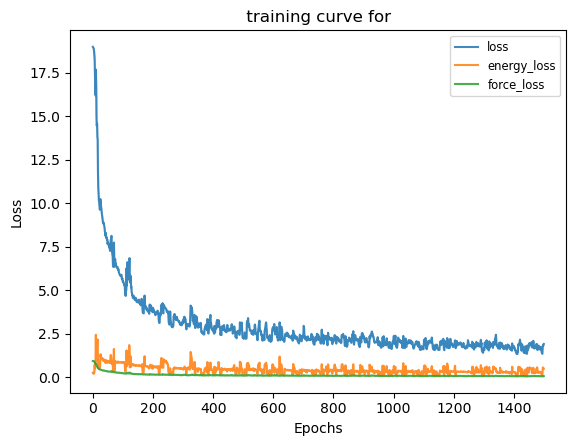

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.moldyn.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange

In [18]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["model_energy"]["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[SetRange(node_coordinates="coords", overwrite=False)],  # To use 
    graph_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, energy="energy", force="forces", atomic_number="nuclear_charges")],
    store_last_input=True,
    update_from_last_input=["range_indices"],  # and "range_images" if periodic.
    update_from_last_input_skip=2    
)

In [19]:
dyn_model(dataset[0:510])[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape:0", shape=(None, 3), dtype=float32), dense_shape=Tensor("gradients/boolean_mask/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


{'energy': array([-17469.47558148]),
 'forces': array([[-2.804563  ,  2.659246  , -0.7892823 ],
        [-0.77832514, -0.87771994,  1.9442754 ],
        [ 3.129744  , -2.218597  , -0.18749745],
        [-0.48035705,  1.7316833 , -0.07104445],
        [ 0.18398109,  1.7970695 ,  0.83623254],
        [-0.47235012,  0.19321363, -0.04799449],
        [ 0.17952225,  0.61065024, -2.0896194 ],
        [-0.3414293 , -1.236336  , -0.04690816],
        [ 0.53390735,  3.9622571 ,  2.0579786 ],
        [-0.7215996 ,  2.1218379 ,  0.70810187],
        [ 1.1924736 , -1.2768817 ,  0.5154243 ],
        [ 0.41930187, -3.8319483 , -1.9493272 ],
        [ 1.6109313 , -0.8815478 , -0.56099075],
        [-0.24501611, -0.5147502 ,  0.3829989 ],
        [ 1.2098049 , -1.8709123 ,  1.3541331 ],
        [ 0.04463744,  0.3586042 , -0.91124356],
        [-1.0372803 ,  0.34886387, -0.18805364],
        [-0.41473922,  0.43155864, -0.23816285],
        [-0.21333042, -1.0866565 , -0.7283828 ],
        [-0.4564288 , 

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [20]:
from ase import Atoms
from kgcnn.moldyn.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [21]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [22]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [-2.82095

In [23]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [24]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [25]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

{'energy': array(-17469.47558168), 'forces': array([[-2.8045626 ,  2.6592467 , -0.7892829 ],
       [-0.77832526, -0.8777199 ,  1.9442754 ],
       [ 3.1297448 , -2.2185988 , -0.18749666],
       [-0.4803572 ,  1.7316846 , -0.07104552],
       [ 0.1839812 ,  1.7970695 ,  0.83623296],
       [-0.47235167,  0.19321394, -0.0479933 ],
       [ 0.17952356,  0.61065024, -2.0896206 ],
       [-0.3414288 , -1.2363359 , -0.04690868],
       [ 0.5339073 ,  3.9622567 ,  2.0579784 ],
       [-0.72160006,  2.1218376 ,  0.70810264],
       [ 1.1924744 , -1.2768826 ,  0.5154244 ],
       [ 0.41930294, -3.8319485 , -1.9493271 ],
       [ 1.6109314 , -0.8815479 , -0.5609906 ],
       [-0.24501586, -0.51475024,  0.38299835],
       [ 1.2098047 , -1.8709128 ,  1.3541337 ],
       [ 0.0446375 ,  0.3586039 , -0.9112433 ],
       [-1.0372809 ,  0.34886378, -0.18805358],
       [-0.41473973,  0.4315585 , -0.23816231],
       [-0.21333052, -1.0866567 , -0.728383  ],
       [-0.45642924,  0.28062367, -0.557619

In [26]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.880eV  Ekin = 0.040eV (T=306K)  Etot = -831.840eV


Energy per atom: Epot = -831.889eV  Ekin = 0.048eV (T=371K)  Etot = -831.841eV
Energy per atom: Epot = -831.892eV  Ekin = 0.051eV (T=392K)  Etot = -831.841eV
Energy per atom: Epot = -831.889eV  Ekin = 0.049eV (T=380K)  Etot = -831.839eV
Energy per atom: Epot = -831.875eV  Ekin = 0.051eV (T=393K)  Etot = -831.824eV
Energy per atom: Epot = -831.886eV  Ekin = 0.051eV (T=398K)  Etot = -831.834eV
Energy per atom: Epot = -831.881eV  Ekin = 0.042eV (T=321K)  Etot = -831.840eV
Energy per atom: Epot = -831.896eV  Ekin = 0.058eV (T=449K)  Etot = -831.838eV
Energy per atom: Epot = -831.893eV  Ekin = 0.057eV (T=439K)  Etot = -831.837eV
Energy per atom: Epot = -831.890eV  Ekin = 0.050eV (T=387K)  Etot = -831.840eV
Energy per atom: Epot = -831.890eV  Ekin = 0.053eV (T=413K)  Etot = -831.837eV
Energy per atom: Epot = -831.883eV  Ekin = 0.045eV (T=352K)  Etot = -831.838eV
Energy per atom: Epot = -831.891eV  Ekin = 0.055eV (T=423K)  Etot = -831.837eV
Energy per atom: Epot = -831.885eV  Ekin = 0.048eV (

In [27]:
calc.model_predictor._last_input

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 1.38326242, -1.25991181, -0.8409088 ],
       [ 0.97419138,  1.31334726, -1.86848229],
       [ 2.09725909, -0.87611386, -2.03342882],
       [ 1.71604177,  0.39120779, -2.55331323],
       [-3.11893915,  2.21552424,  0.1054147 ],
       [ 0.5240694 , -0.3781321 , -0.12137524],
       [ 0.29545857,  0.87723147, -0.70621603],
       [-0.27932477,  0.16180511,  2.06270999],
       [-2.20805798, -0.04775957,  0.26407095],
       [ 0.37496065, -1.92040696,  1.57470019],
       [ 0.11797669, -0.63876435,  1.24829722],
       [-2.03212175,  1.12226774,  0.05014498],
       [-0.77847872,  1.67145138, -0.25167996],
       [ 0.23857083, -2.01571363,  2.51779539],
       [ 1.65087536, -2.22391696, -0.30772541],
       [ 0.80109877,  2.28099667, -2.39898684],
       [ 2.69779291, -1.58693743, -2.56433577],
       [ 2.03762743,  0.86050433, -3.54682269],
       [-3.78660